In [1]:
print("hello world")

hello world


In [ ]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms # .v2 as transforms
from torchvision.models import resnet50
from torch.amp import GradScaler

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics, print_training_statistics
from classes.RetinaDataset import RetinaDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Transformation & Augmentation

In [3]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

mean = np.array(mean, dtype=np.float32, copy=True)
std = np.array(std, dtype=np.float32, copy=True)

mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


ResNet50 gets 256*256 tensors

In [4]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

# Single augmentation transform with random applications
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15)  # Reduced from 30 to preserve medical image integrity
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

## 2. Data Loading

In [5]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented,  # Use augmented transform with random applications
    type_of_classification='binary'
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

## 3. ResNet50 definition

In [6]:
NUMBER_OF_LABELS = 1 

model = resnet50(weights="IMAGENET1K_V2") # https://docs.pytorch.org/vision/stable/models.html#convolutional-neural-networks 
model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 

for param in model.parameters(): # first layers frozen
    param.requires_grad = False
for param in model.fc.parameters(): # last layer trainable
    param.requires_grad = True

## 4. Loss definition

In [ ]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([401 / 1519], device=device))  
# Adjust pos_weight as needed for class imbalance according to the EDA results

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = GradScaler()  # For Automatic Mixed Precision

## 5. Model training

In [8]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_test_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 30

In [9]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device,
        num_labels=NUMBER_OF_LABELS,
        scaler=scaler)
    
    # Print metrics
    print_training_statistics(
        train_loss, train_accuracy, train_f1, train_roc_auc, 
        test_loss, test_accuracy, test_f1, test_roc_auc,
        get_device_properties=True, memory_allocated=True, memory_reserved=True
    )
    
    scheduler.step(test_loss) 
    
    # Early stopping 
    if epoch > 15:
        if (best_test_loss - test_loss) > min_delta:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)



Epoch number: 0


100%|██████████| 15/15 [00:52<00:00,  3.49s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.6722 | Train Accuracy: 0.6344 | Train F1-score: 0.7539 | Train ROC-AUC: 0.5617 |
| Test Loss:  0.6263 | Test Accuracy:  0.7875 | Test F1-score:  0.8811 | Test ROC-AUC:  0.6790 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 1


100%|██████████| 15/15 [00:58<00:00,  3.92s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.6070 | Train Accuracy: 0.7891 | Train F1-score: 0.8820 | Train ROC-AUC: 0.5808 |
| Test Loss:  0.5733 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.7405 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 2


100%|██████████| 15/15 [01:00<00:00,  4.01s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5595 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.6238 |
| Test Loss:  0.5308 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.7640 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 3


100%|██████████| 15/15 [00:59<00:00,  3.96s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5281 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.6762 |
| Test Loss:  0.5053 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.7841 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 4


100%|██████████| 15/15 [01:00<00:00,  4.02s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5108 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.6835 |
| Test Loss:  0.4877 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8000 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 5


100%|██████████| 15/15 [01:00<00:00,  4.03s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4972 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.6936 |
| Test Loss:  0.4773 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8158 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 6


100%|██████████| 15/15 [00:58<00:00,  3.92s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4892 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.7191 |
| Test Loss:  0.4657 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8364 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 7


100%|██████████| 15/15 [01:00<00:00,  4.01s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4775 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.7606 |
| Test Loss:  0.4576 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8467 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 8


100%|██████████| 15/15 [00:58<00:00,  3.92s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4791 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.7361 |
| Test Loss:  0.4517 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8642 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 9


100%|██████████| 15/15 [00:59<00:00,  3.98s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4665 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.7853 |
| Test Loss:  0.4435 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8691 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 10


100%|██████████| 15/15 [01:00<00:00,  4.05s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4635 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.7842 |
| Test Loss:  0.4380 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8803 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 11


100%|██████████| 15/15 [00:53<00:00,  3.59s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4588 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.7976 |
| Test Loss:  0.4310 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8869 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 12


100%|██████████| 15/15 [00:51<00:00,  3.43s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4539 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.8064 |
| Test Loss:  0.4247 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8917 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 13


100%|██████████| 15/15 [00:50<00:00,  3.38s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4513 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.8096 |
| Test Loss:  0.4193 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8973 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 14


100%|██████████| 15/15 [00:51<00:00,  3.45s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4465 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.8182 |
| Test Loss:  0.4140 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.9038 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 15


100%|██████████| 15/15 [00:48<00:00,  3.24s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4404 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.8261 |
| Test Loss:  0.4103 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.9092 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 16


100%|██████████| 15/15 [00:49<00:00,  3.29s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4394 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.8274 |
| Test Loss:  0.4064 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.9127 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 17


100%|██████████| 15/15 [00:50<00:00,  3.36s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4359 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.8305 |
| Test Loss:  0.3991 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.9145 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 18


100%|██████████| 15/15 [00:48<00:00,  3.24s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4288 | Train Accuracy: 0.7917 | Train F1-score: 0.8837 | Train ROC-AUC: 0.8446 |
| Test Loss:  0.3937 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.9173 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 19


100%|██████████| 15/15 [00:49<00:00,  3.30s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4284 | Train Accuracy: 0.7911 | Train F1-score: 0.8834 | Train ROC-AUC: 0.8370 |
| Test Loss:  0.3884 | Test Accuracy:  0.7922 | Test F1-score:  0.8838 | Test ROC-AUC:  0.9185 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 20


100%|██████████| 15/15 [00:49<00:00,  3.28s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4258 | Train Accuracy: 0.7917 | Train F1-score: 0.8837 | Train ROC-AUC: 0.8418 |
| Test Loss:  0.3859 | Test Accuracy:  0.7953 | Test F1-score:  0.8854 | Test ROC-AUC:  0.9225 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 21


100%|██████████| 15/15 [00:48<00:00,  3.25s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4218 | Train Accuracy: 0.7922 | Train F1-score: 0.8839 | Train ROC-AUC: 0.8436 |
| Test Loss:  0.3815 | Test Accuracy:  0.7953 | Test F1-score:  0.8854 | Test ROC-AUC:  0.9237 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 22


100%|██████████| 15/15 [00:49<00:00,  3.28s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4183 | Train Accuracy: 0.7922 | Train F1-score: 0.8839 | Train ROC-AUC: 0.8499 |
| Test Loss:  0.3786 | Test Accuracy:  0.7953 | Test F1-score:  0.8852 | Test ROC-AUC:  0.9263 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 23


100%|██████████| 15/15 [00:49<00:00,  3.33s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4122 | Train Accuracy: 0.7927 | Train F1-score: 0.8842 | Train ROC-AUC: 0.8592 |
| Test Loss:  0.3735 | Test Accuracy:  0.7984 | Test F1-score:  0.8867 | Test ROC-AUC:  0.9274 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 24


100%|██████████| 15/15 [00:56<00:00,  3.77s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4193 | Train Accuracy: 0.7927 | Train F1-score: 0.8841 | Train ROC-AUC: 0.8389 |
| Test Loss:  0.3764 | Test Accuracy:  0.8062 | Test F1-score:  0.8907 | Test ROC-AUC:  0.9306 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 25


100%|██████████| 15/15 [00:59<00:00,  4.00s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4076 | Train Accuracy: 0.7958 | Train F1-score: 0.8856 | Train ROC-AUC: 0.8590 |
| Test Loss:  0.3668 | Test Accuracy:  0.8109 | Test F1-score:  0.8930 | Test ROC-AUC:  0.9302 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 26


100%|██████████| 15/15 [00:57<00:00,  3.81s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4023 | Train Accuracy: 0.7969 | Train F1-score: 0.8860 | Train ROC-AUC: 0.8665 |
| Test Loss:  0.3624 | Test Accuracy:  0.8219 | Test F1-score:  0.8986 | Test ROC-AUC:  0.9318 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 27


100%|██████████| 15/15 [00:59<00:00,  3.97s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4089 | Train Accuracy: 0.7958 | Train F1-score: 0.8856 | Train ROC-AUC: 0.8460 |
| Test Loss:  0.3599 | Test Accuracy:  0.8266 | Test F1-score:  0.9010 | Test ROC-AUC:  0.9333 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 28


100%|██████████| 15/15 [00:58<00:00,  3.90s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4042 | Train Accuracy: 0.7974 | Train F1-score: 0.8861 | Train ROC-AUC: 0.8577 |
| Test Loss:  0.3565 | Test Accuracy:  0.8359 | Test F1-score:  0.9050 | Test ROC-AUC:  0.9342 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 29


100%|██████████| 15/15 [00:58<00:00,  3.91s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4008 | Train Accuracy: 0.8005 | Train F1-score: 0.8876 | Train ROC-AUC: 0.8641 |
| Test Loss:  0.3552 | Test Accuracy:  0.8391 | Test F1-score:  0.9066 | Test ROC-AUC:  0.9356 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------


In [10]:
torch.save(model.state_dict(), '../Models/model_ft_resnet50_bc.pth')

In [11]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_model_ft_resnet50_bc.csv', index=False)

## 6. Evolution of the training

In [12]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_model_ft_resnet50_bc.csv')

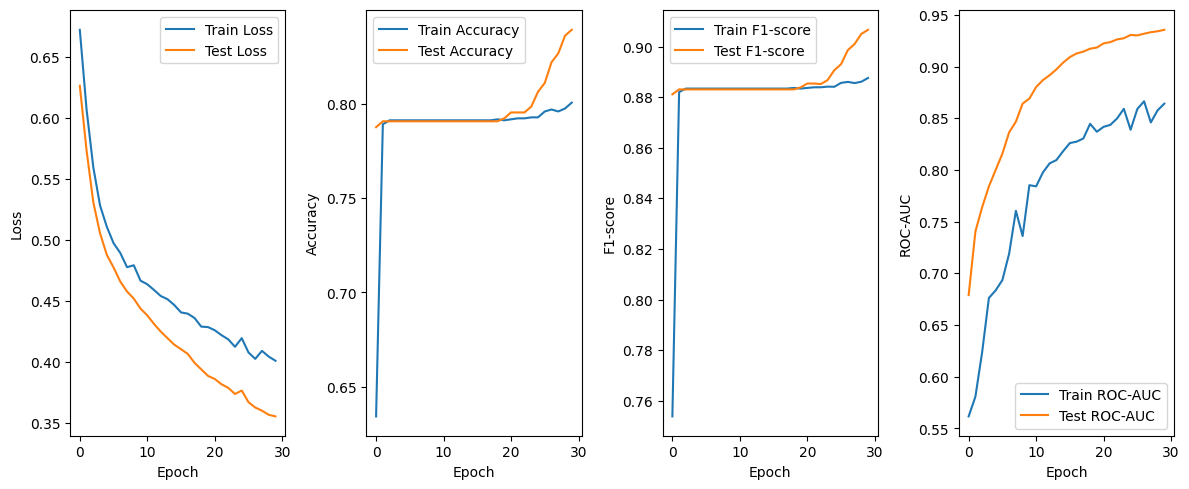

In [13]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_resnet50_bc_zoomed.png',
    title='Training Evolution - Fine Tuned ResNet50 Binary Classification Zoomed',
    zoomed=True
)


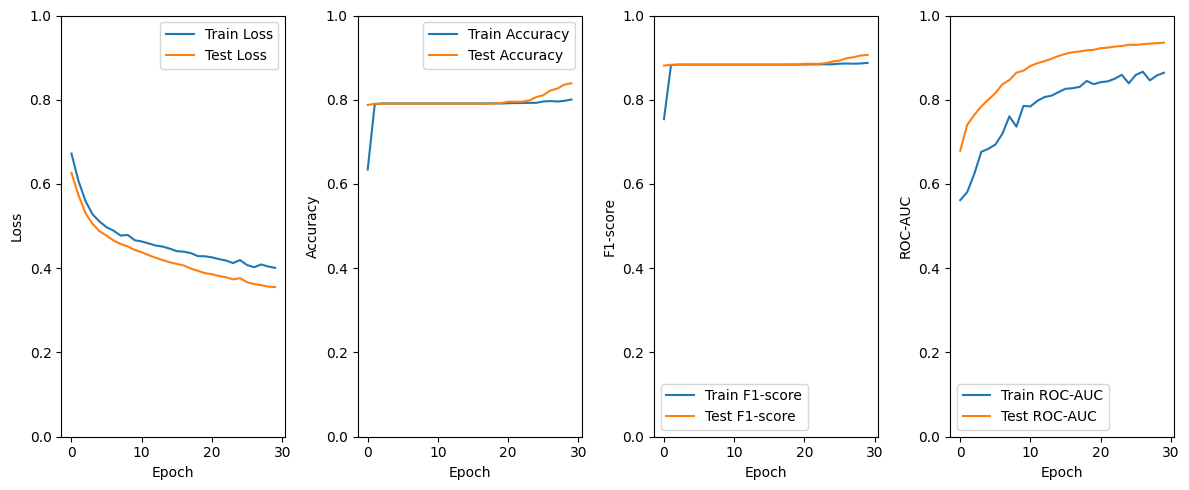

In [14]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_resnet50_bc.png',
    title='Training Evolution - Fine Tuned ResNet50 Binary Classification',
    zoomed=False
)


## 7. Model evaluation

In [15]:
model = resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 
model.load_state_dict(torch.load('../Models/model_ft_resnet50_bc.pth', weights_only=True))

<All keys matched successfully>

In [16]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device=device, num_labels=NUMBER_OF_LABELS)

In [17]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.3755 | Validation Accuracy: 0.7969 | Validation F1-score: 0.8850 | Validation ROC-AUC: 0.9140
